1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



Text(0, 0.5, 'Cumulative probability')

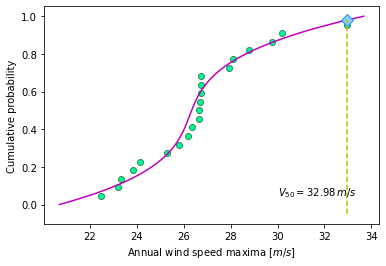

In [32]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

cprob = (np.arange(years_nb)+1)/(years_nb+1)
sorted_max_speeds = np.sort(max_speeds)
quantile_func = UnivariateSpline(cprob, sorted_max_speeds)

nprob = np.linspace(0, 1, 100)
fitted_max_speeds = quantile_func(nprob)
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)

plt.figure()
plt.plot(sorted_max_speeds, cprob, 'o', mfc='mediumspringgreen', mec='seagreen')
plt.plot(fitted_max_speeds, nprob, 'm-')
plt.plot([fifty_wind], [fifty_prob], 'D', ms=8., mfc='lightskyblue', mec='dodgerblue')
plt.text(30, 0.05, '$V_{50} = %.2f \, m/s$' % fifty_wind)
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], 'y--')
plt.xlabel('Annual wind speed maxima [$m/s$]')
plt.ylabel('Cumulative probability')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

A function that could fit the data is a gaussian, for both the trends
Here we have respectively standard deviation, mean, a moltiplicative factor and a costant that minimizes the chi-squared for the maximas temperatures: [  2.29443154   6.73581554 132.80912778  15.77934559]
and for minimas: [  1.97590004   7.16452601 260.76388083 -61.32093513]


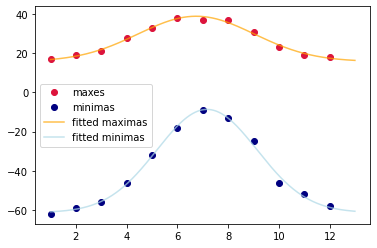

The two fit are a good representation of the data.
anyway there is an offset between the centroids of: -0.42871047113123684


In [33]:
from scipy import optimize

maxes=np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
minimas=np.array([ -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
x=np.arange(12)+1
x_fit= np.arange(0,12,0.01)+1

print('A function that could fit the data is a gaussian, for both the trends')
def gauss(x,sigma,mu,factor,cost):
    return (factor*(1/(sigma*(2*np.pi)**.5))*np.exp(-(x-mu)**2/(2*sigma**2))+cost)

params_max, params_covariance_max = optimize.curve_fit(gauss, x, maxes, p0=[1,7,260,18])
params_min, params_covariance_min = optimize.curve_fit(gauss, x, minimas, p0=[1,7,260,-60])
print('Here we have respectively standard deviation, mean, a moltiplicative factor and a costant that minimizes the chi-squared for the maximas temperatures:', params_max)
print('and for minimas:', params_min)

plt.plot(x, maxes, 'o', color='crimson', label='maxes')
plt.plot(x, minimas, 'o', color='navy', label='minimas')
plt.plot(x_fit,gauss(x_fit,*params_max), '-', color='orange', alpha=0.7, label='fitted maximas')
plt.plot(x_fit,gauss(x_fit,*params_min), '-', color='lightblue', alpha=0.7, label='fitted minimas')
plt.legend()
plt.show()
print('The two fit are a good representation of the data.')
print('anyway there is an offset between the centroids of:',params_max[1]-params_min[1])

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


It seems there are two local minima at (0.0,-0.75),(0.0,0.75)
the coordinates of the two minima are: [ 0.08985543 -0.71264841]  and  [-0.08986417  0.71266077] 
 the function assume respectively the two values -1.0316284521568724  and  -1.0316284515157363
when the guess is [0,0] the value of the funcion is 0.0 and the cooridnates are [0. 0.]


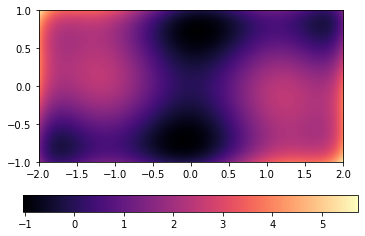

In [34]:
def camelback(xy):
    return ((4-2.1*xy[0]**2+xy[0]**4/3)*xy[0]**2+xy[0]*xy[1]+(4*xy[1]**2-4)*xy[1]**2)
x=np.arange(-2,2,0.002)
y=np.arange(-1,1,0.001)

newx,newy=np.meshgrid(x,y)
imagetoplot=plt.imshow(camelback([newx,newy]), cmap='magma', extent= [-2,2,-1,1])
plt.colorbar(imagetoplot, orientation='horizontal')

print('It seems there are two local minima at (0.0,-0.75),(0.0,0.75)')
opt1=optimize.minimize(camelback, [0.0,-0.75], method='Nelder-Mead')
opt2=optimize.minimize(camelback, [0.0,0.75],method='Nelder-Mead')
print('the coordinates of the two minima are:',opt1.x,' and ', opt2.x, '\n','the function assume respectively the two values', opt1.fun,' and ',opt2.fun)

opt0=optimize.minimize(camelback, [0,0])
print('when the guess is [0,0] the value of the funcion is',opt0.fun, 'and the cooridnates are', opt0.x)

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

Text(0, 0.5, 'power as MSA')

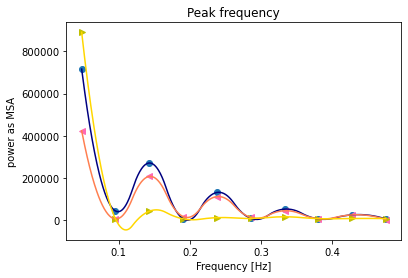

In [37]:
from scipy import fftpack
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

data = np.loadtxt('populations.txt')
year=data[::,0]
hares=data[::,1]
lynxes=data[::,2]
carrots=data[::,3]

hfft = fftpack.fft(hares)
lfft = fftpack.fft(lynxes)
cfft = fftpack.fft(carrots)
hpower = np.abs(hfft)
lpower = np.abs(lfft)
cpower = np.abs(cfft)
hfreq = fftpack.fftfreq(hares.size, d=1)
lfreq = fftpack.fftfreq(lynxes.size, d=1)
cfreq = fftpack.fftfreq(carrots.size, d=1)

hpos_mask = np.where(hfreq > 0)
hfreq = hfreq[hpos_mask]
lpos_mask = np.where(lfreq > 0)
lfreq = lfreq[lpos_mask]
cpos_mask = np.where(cfreq > 0)
cfreq = cfreq[cpos_mask]

plt.title('Peak frequency')
plt.plot(hfreq, hpower[:10], 'o')
plt.plot(lfreq, lpower[:10], '<', color='hotpink')
plt.plot(cfreq, cpower[:10], '>', color='y')

x=np.linspace(hfreq.min(), hfreq.max(),500)
f=interp1d(hfreq, hpower[:10], kind='quadratic')
hsmooth=f(x)
x1=np.linspace(lfreq.min(), lfreq.max(),500)
f=interp1d(lfreq,lpower[:10], kind='quadratic')
lsmooth=f(x1)
x2=np.linspace(cfreq.min(), cfreq.max(),500)
f=interp1d(cfreq,cpower[:10], kind='quadratic')
csmooth=f(x2)
plt.plot (x,hsmooth,color='navy')
plt.plot (x1,lsmooth,color='coral')
plt.plot (x2,csmooth,color='gold')

plt.xlabel('Frequency [Hz]')
plt.ylabel('power as MSA')

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Text(0.5, 1.0, 'Fourier transform in logarithmic scale')

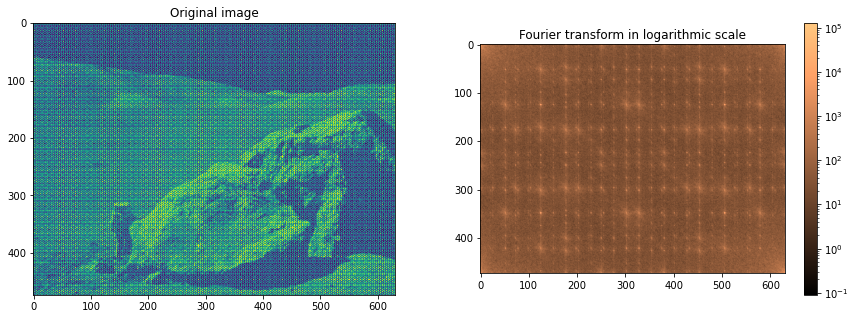

In [38]:
im = plt.imread('moonlanding.png').astype(float)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.imshow(im)
ax1.set_title('Original image')


from scipy import fftpack
from matplotlib.colors import LogNorm

imfft=fftpack.fft2(im)
imm=ax2.imshow(np.abs(imfft), norm=LogNorm(), cmap='copper')
fig.colorbar(imm, ax=ax2)
ax2.set_title('Fourier transform in logarithmic scale')

Text(0.5, 1.0, 'Reconstructed Image')

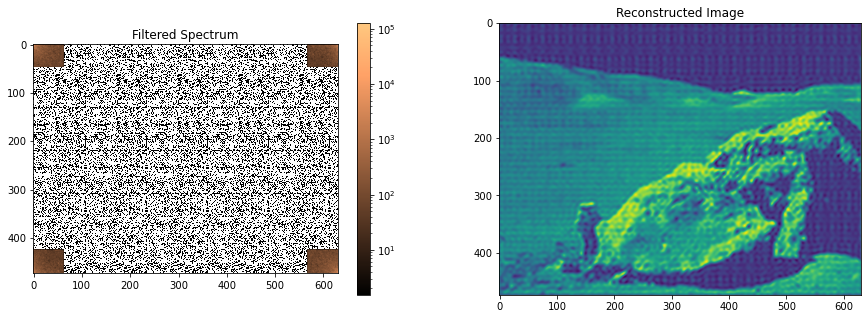

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

keep_fraction = 0.1
im_fft2 = imfft.copy()
r,c=im_fft2.shape
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

immnew=ax1.imshow(np.abs(im_fft2), cmap='copper', norm=LogNorm())
fig.colorbar(immnew, ax=ax1)
ax1.set_title('Filtered Spectrum')

im_new = fftpack.ifft2(im_fft2).real

ax2.imshow(im_new)
ax2.set_title('Reconstructed Image')